In [1]:
! pip install surgeon-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.7/42.7 kB 2.6 MB/s eta 0:00:00


In [2]:
pip install --upgrade transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 125.3 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.2
    Uninstalling transformers-4.46.2:
      Successfully uninstalled transformers-4.46.2


In [3]:
!pip install transformers timm matplotlib scikit-learn


In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from surgeon_pytorch import Inspect, get_layers
import os, random, pathlib, warnings, itertools, math
from torchvision.transforms import Resize, ToTensor
from torch.utils.data import DataLoader, Subset
from PIL import Image
from transformers import AutoModel, AutoImageProcessor
from torchvision.transforms import Resize, ToTensor, Compose, ToPILImage


In [5]:
# List contents of the directory to confirm
!ls /content/sample_data/shapes

# Remove the .ipynb_checkpoints directory
!rm -r /content/sample_data/shapes/.ipynb_checkpoints

# List again to verify deletion
!ls /content/sample_data/shapes


ls: cannot access '/content/sample_data/shapes': No such file or directory
rm: cannot remove '/content/sample_data/shapes/.ipynb_checkpoints': No such file or directory
ls: cannot access '/content/sample_data/shapes': No such file or directory


In [6]:
!rm -r /content/sample_data/shapes/square/.ipynb_checkpoints


rm: cannot remove '/content/sample_data/shapes/square/.ipynb_checkpoints': No such file or directory


Number of classes: 5
Class names and sample counts: {'square': 15, 'circle': 15, 'triangle': 15, 'trapezoid': 15, 'star': 15}


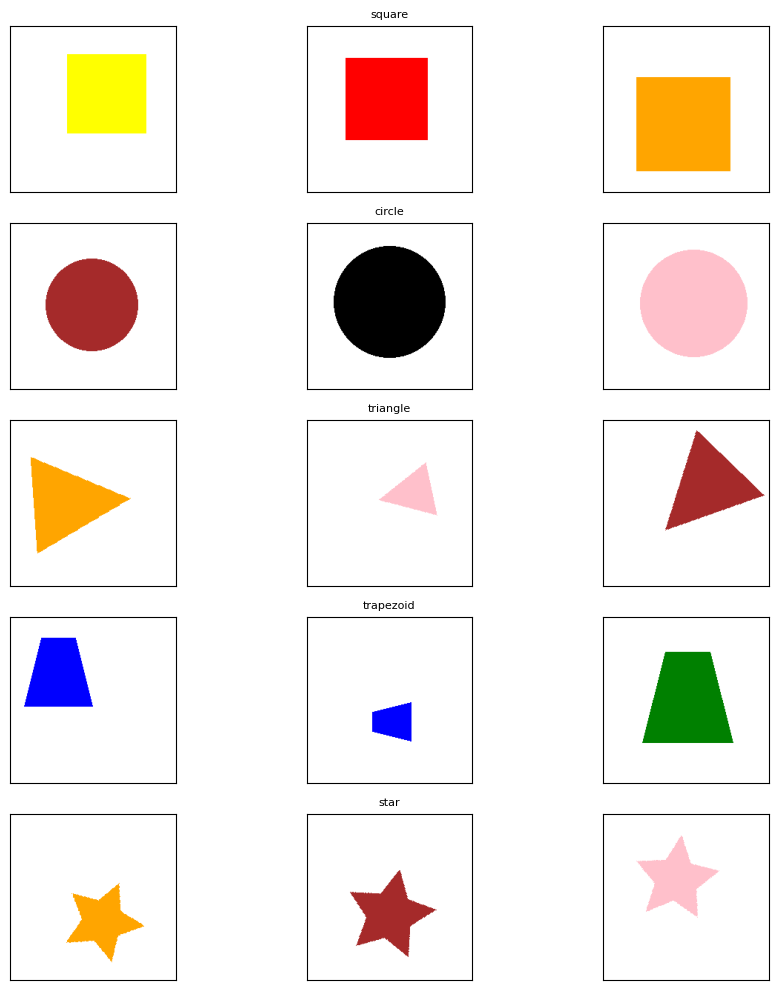

In [8]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Path to the dataset
data_path = '/content/sample_data/shapes'

# Function to count classes and their samples
def count_classes_and_samples(data_path):
    class_counts = {}
    class_names = []

    for label in os.listdir(data_path):
        label_path = os.path.join(data_path, label)
        if os.path.isdir(label_path):
            num_samples = len(os.listdir(label_path))
            class_counts[label] = num_samples
            class_names.append(label)

    return class_names, class_counts

# Function to plot minimized class samples
def plot_class_samples(data_path, num_samples=3):
    class_names, class_counts = count_classes_and_samples(data_path)

    print(f"Number of classes: {len(class_names)}")
    print(f"Class names and sample counts: {class_counts}")

    # Adjust figure size for smaller images
    plt.figure(figsize=(10, len(class_names) * 2))

    for idx, class_name in enumerate(class_names):
        class_path = os.path.join(data_path, class_name)
        images = os.listdir(class_path)[:num_samples]

        for i, image_name in enumerate(images):
            image_path = os.path.join(class_path, image_name)
            try:
                image = Image.open(image_path).convert("RGB")

                # Subplots with smaller images
                plt.subplot(len(class_names), num_samples, idx * num_samples + i + 1)
                plt.imshow(image)
                plt.xticks([])
                plt.yticks([])
                if i == 1:  # Center the class name over the middle image
                    plt.title(class_name, fontsize=8)
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")

    plt.tight_layout()
    plt.show()

# Execute the plotting function
plot_class_samples(data_path, num_samples=3)


In [9]:
import os
from PIL import Image
from torchvision.transforms import functional as TF

# Path to the dataset
data_dir = '/content/sample_data/shapes'

# Function to convert dataset images to grayscale
def convert_dataset_to_grayscale(data_dir):
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                # Open the image
                with Image.open(file_path) as img:
                    # Convert to grayscale
                    gray_img = TF.to_grayscale(img, num_output_channels=3)  # Keeps 3 channels for compatibility

                    # Save the image (overwrite original)
                    gray_img.save(file_path)
                    print(f"Converted: {file_path}")
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")

# Execute the function
convert_dataset_to_grayscale(data_dir)


Converted: /content/sample_data/shapes/square/square_13.png
Converted: /content/sample_data/shapes/square/square_7.png
Converted: /content/sample_data/shapes/square/square_4.png
Converted: /content/sample_data/shapes/square/square_15.png
Converted: /content/sample_data/shapes/square/square_8.png
Converted: /content/sample_data/shapes/square/square_10.png
Converted: /content/sample_data/shapes/square/square_3.png
Converted: /content/sample_data/shapes/square/square_9.png
Converted: /content/sample_data/shapes/square/square_2.png
Converted: /content/sample_data/shapes/square/square_12.png
Converted: /content/sample_data/shapes/square/square_5.png
Converted: /content/sample_data/shapes/square/square_1.png
Converted: /content/sample_data/shapes/square/square_11.png
Converted: /content/sample_data/shapes/square/square_6.png
Converted: /content/sample_data/shapes/square/square_14.png
Converted: /content/sample_data/shapes/circle/circle_5.png
Converted: /content/sample_data/shapes/circle/circ

Class: square


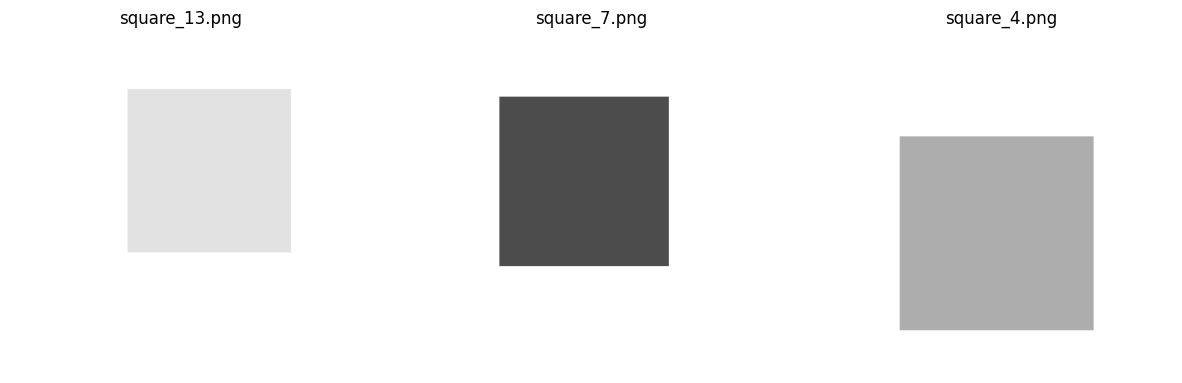

Class: circle


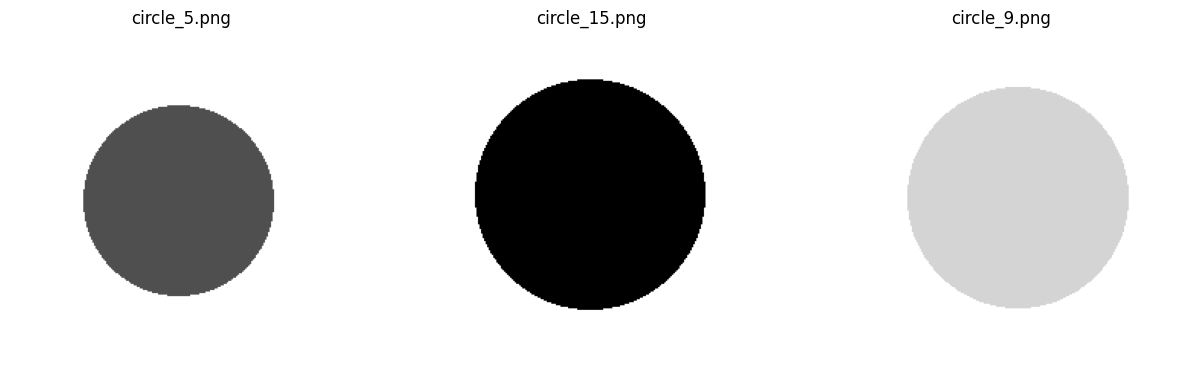

Class: triangle


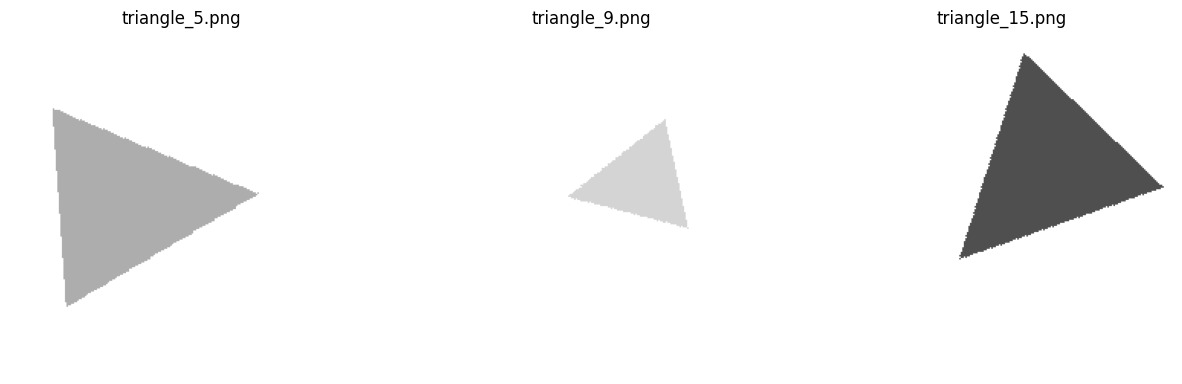

Class: trapezoid


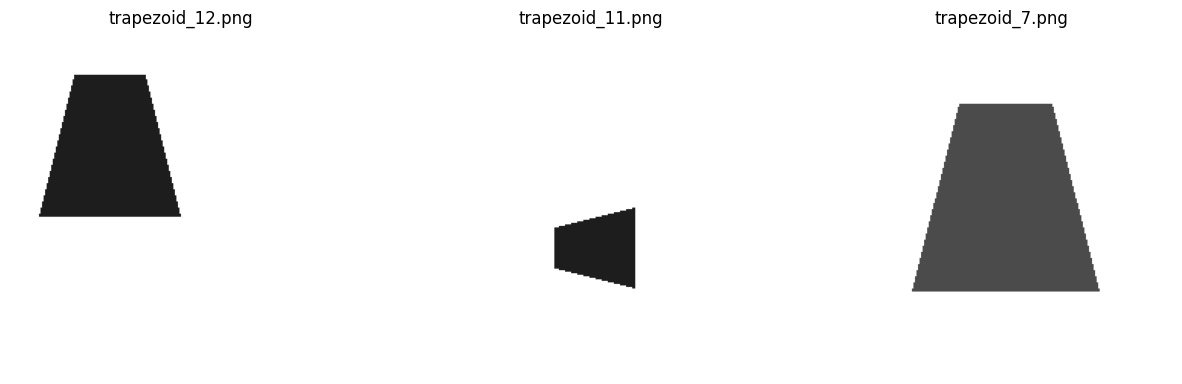

Class: star


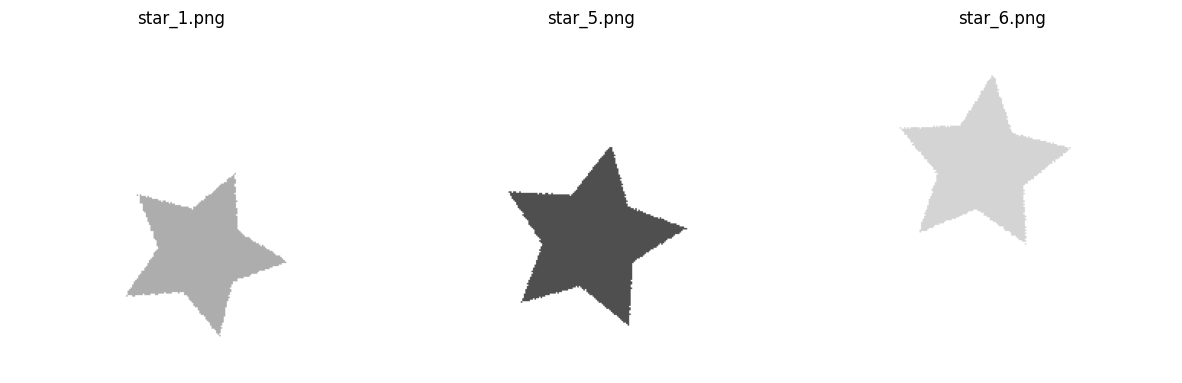

In [10]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Path to the dataset
data_dir = '/content/sample_data/shapes'

# Function to display a few images from each class
def display_sample_images(data_dir, num_samples=3):
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)

        # Skip non-directory files
        if not os.path.isdir(class_path):
            continue

        print(f"Class: {class_name}")
        images = os.listdir(class_path)[:num_samples]  # Select a few images
        plt.figure(figsize=(15, 5))

        for i, image_name in enumerate(images):
            image_path = os.path.join(class_path, image_name)
            try:
                img = Image.open(image_path)
                plt.subplot(1, num_samples, i + 1)
                plt.imshow(img, cmap='gray')  # Show in grayscale
                plt.title(image_name)
                plt.axis('off')
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")

        plt.show()

# Display images from the dataset
display_sample_images(data_dir, num_samples=3)


In [36]:
from transformers import AutoModel

# Load your model
model_name = "facebook/dinov2-large"
model = AutoModel.from_pretrained(model_name)

# Print all layer names
for name, module in model.named_modules():
    print(name)



embeddings
embeddings.patch_embeddings
embeddings.patch_embeddings.projection
embeddings.dropout
encoder
encoder.layer
encoder.layer.0
encoder.layer.0.norm1
encoder.layer.0.attention
encoder.layer.0.attention.attention
encoder.layer.0.attention.attention.query
encoder.layer.0.attention.attention.key
encoder.layer.0.attention.attention.value
encoder.layer.0.attention.attention.dropout
encoder.layer.0.attention.output
encoder.layer.0.attention.output.dense
encoder.layer.0.attention.output.dropout
encoder.layer.0.layer_scale1
encoder.layer.0.drop_path
encoder.layer.0.norm2
encoder.layer.0.mlp
encoder.layer.0.mlp.fc1
encoder.layer.0.mlp.activation
encoder.layer.0.mlp.fc2
encoder.layer.0.layer_scale2
encoder.layer.1
encoder.layer.1.norm1
encoder.layer.1.attention
encoder.layer.1.attention.attention
encoder.layer.1.attention.attention.query
encoder.layer.1.attention.attention.key
encoder.layer.1.attention.attention.value
encoder.layer.1.attention.attention.dropout
encoder.layer.1.attention.

**facebook/dinov2-large**

The Vision Transformer (ViT) is a transformer encoder model (BERT-like) pretrained on a large collection of images in a self-supervised fashion.

**Note** that this model does not include any fine-tuned heads.

[https://huggingface.co/facebook/dinov2-large-imagenet1k-1-layer]

In [ ]:
from transformers import AutoModel

# Load the pretrained DINOv2 model
model_name = "facebook/dinov2-large"
model = AutoModel.from_pretrained(model_name)  # Load the model
model.eval()  # Set the model to evaluation mode

# Print the model structure to explore layer names
print(model)


Dinov2Model(
  (embeddings): Dinov2Embeddings(
    (patch_embeddings): Dinov2PatchEmbeddings(
      (projection): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Dinov2Encoder(
    (layer): ModuleList(
      (0-23): 24 x Dinov2Layer(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attention): Dinov2SdpaAttention(
          (attention): Dinov2SdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): Dinov2SelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (layer_scale1): Dinov2LayerScale()
      

**Pipeline**

In [21]:
# Function to extract, visualize, save, and show combined latent representations
def extract_visualize_save_and_show_tsne(model, feature_extractor, images, layer_names, num_classes, save_path="tsne_plots.png"):

    import numpy as np
    import torch
    from torch.utils.data import DataLoader
    from torchvision.transforms import ToPILImage
    import matplotlib.pyplot as plt
    from sklearn.manifold import TSNE

    all_activations = []  # Combined activations across layers
    all_labels = []  # Ground truth labels
    all_images = []  # To track image names
    layer_labels = []  # To track the layer index of each activation

    # DataLoader for batch processing
    data_loader = DataLoader(images, batch_size=32, shuffle=False)
    to_pil = ToPILImage()  # Convert tensors back to PIL images

    # Forward hooks to capture activations from specific layers
    hooks = []

    # Hook function to handle tuple outputs and flatten activations
    def create_hook(layer_name, layer_idx):
        def hook_fn(module, input, output):
            if isinstance(output, tuple):
                output = output[0]  # Use the first element if it's a tuple
            flat_output = output.view(output.size(0), -1)  # Flatten spatial dimensions
            all_activations.append(flat_output.detach().cpu().numpy())  # Append activations
            layer_labels.extend([layer_idx] * flat_output.size(0))  # Track which layer the activations belong to
        return hook_fn

    # Attach hooks to the specified layers
    for idx, layer_name in enumerate(layer_names):
        try:
            layer = dict([*model.named_modules()])[layer_name]
            hooks.append(layer.register_forward_hook(create_hook(layer_name, idx)))
        except KeyError:
            print(f"Layer {layer_name} not found. Check the model structure:")
            for name, _ in model.named_modules():
                print(name)
            return

    # Process the data
    for batch_idx, (batch, target) in enumerate(data_loader):
        pil_images = [to_pil(img) for img in batch]  # Convert tensors back to PIL images
        image_names = [images.imgs[idx][0] for idx in range(len(all_images), len(all_images) + len(batch))]
        all_images.extend(image_names)  # Save image names

        with torch.no_grad():
            inputs = feature_extractor(images=pil_images, return_tensors="pt")["pixel_values"]
            inputs = inputs.to("cuda" if torch.cuda.is_available() else "cpu")
            model(inputs)

            # Expand class labels for each layer
            repeated_labels = np.tile(target.numpy(), len(layer_names))
            all_labels.extend(repeated_labels)

    # Remove hooks after processing
    for hook in hooks:
        hook.remove()

    # Concatenate activations and labels
    all_activations = np.concatenate(all_activations, axis=0)
    all_labels = np.array(all_labels)  # Convert list to NumPy array
    layer_labels = np.array(layer_labels)

    # Save data for later use
    np.save("activations.npy", all_activations)
    np.save("labels.npy", all_labels)
    np.save("image_names.npy", np.array(all_images))

    # Apply T-SNE to combined activations
    tsne = TSNE(n_components=2, perplexity=min(30, len(all_labels) - 1), random_state=0)
    reduced_activations = tsne.fit_transform(all_activations)

    # Create side-by-side plots for classes and layers
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Plot T-SNE by classes
    class_colors = ['blue', 'red', '#C4A000', 'green', 'purple']  # Define custom colors for classes
    scatter_classes = axes[0].scatter(
        reduced_activations[:, 0],
        reduced_activations[:, 1],
        c=[class_colors[label % len(class_colors)] for label in all_labels],
        alpha=0.7,
        s=10
    )
    axes[0].set_title('T-SNE Visualization by Class')
    axes[0].set_xlabel('Component 1')
    axes[0].set_ylabel('Component 2')

    # Plot T-SNE by layers with single numbers
    unique_layers = np.unique(layer_labels)
    cmap = plt.get_cmap('tab10')  # Use a colormap for layers

    for i, layer_idx in enumerate(unique_layers):
        layer_mask = layer_labels == layer_idx
        layer_points = reduced_activations[layer_mask]
        axes[1].scatter(
            layer_points[:, 0],
            layer_points[:, 1],
            label=f'{layer_names[layer_idx]}',
            alpha=0.7,
            s=10
        )
        # Calculate the centroid for this layer
        centroid_x, centroid_y = layer_points.mean(axis=0)
        axes[1].text(
            centroid_x,
            centroid_y,
            str(layer_idx),
            fontsize=12,
            color='darkgreen',
            fontweight='bold'
        )

    axes[1].set_title('T-SNE Visualization by Layer')
    axes[1].set_xlabel('Component 1')
    axes[1].set_ylabel('Component 2')
    axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)  # Move legend to the side

    # Save and show the plot
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)  # Save with high resolution (300 DPI)
    plt.show()  # Show the plot
    plt.close()  # Close the plot



**Model1: facebook/dinov2-large-imagenet**

In [ ]:
from transformers import AutoModel

# Load your model
model_name = "facebook/dinov2-large"
model = AutoModel.from_pretrained(model_name)
print (model)
# Print all layer names
for name, module in model.named_modules():
    print(name)


Dinov2Model(
  (embeddings): Dinov2Embeddings(
    (patch_embeddings): Dinov2PatchEmbeddings(
      (projection): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Dinov2Encoder(
    (layer): ModuleList(
      (0-23): 24 x Dinov2Layer(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attention): Dinov2SdpaAttention(
          (attention): Dinov2SdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): Dinov2SelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (layer_scale1): Dinov2LayerScale()
      

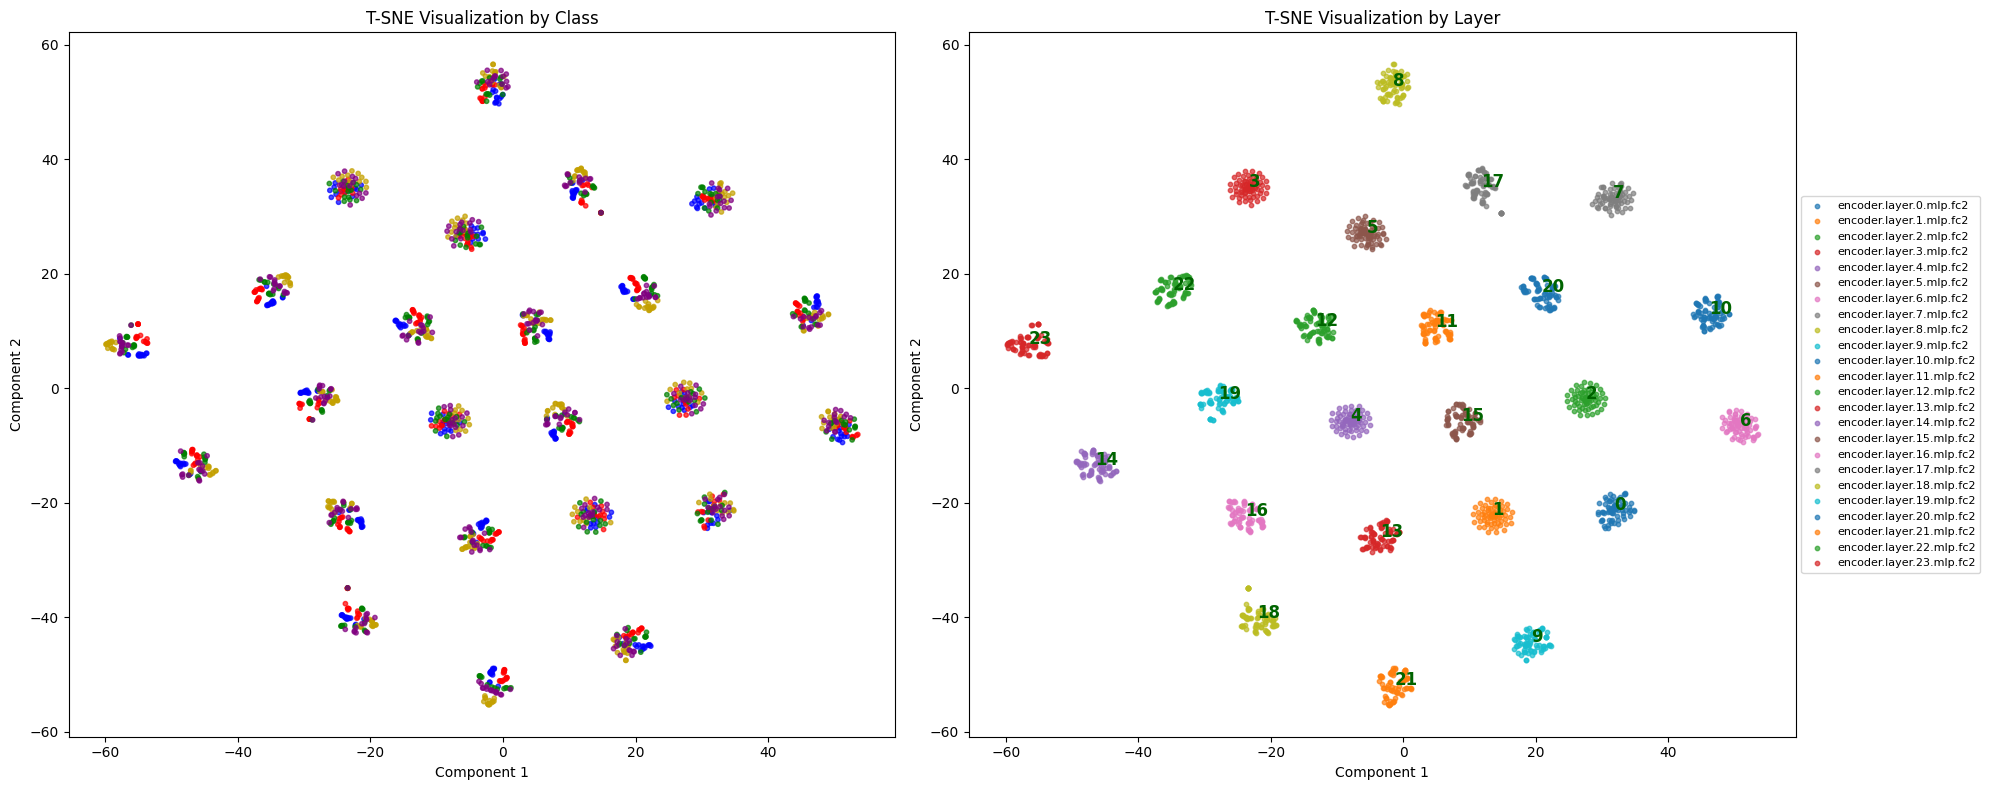

In [22]:
# Load the DINOv2 model and feature extractor
model_name = "facebook/dinov2-large-imagenet1k-1-layer"
model = AutoModel.from_pretrained(model_name)

# Suppress uninitialized pooler weights warning
if hasattr(model, 'pooler'):
    model.pooler = None  # Remove the pooler layer if it exists

feature_extractor = AutoImageProcessor.from_pretrained(model_name)

# Move the model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device).eval()

# Define the dataset
data_dir = "/content/sample_data/shapes"
transform = Compose([
    Resize((224, 224)),  # Update resolution based on model requirements
    ToTensor(),  # Keep data in [0, 1] range
])
dataset = ImageFolder(data_dir, transform=transform)

# Define the MLP layers to analyze
layers_to_analyze_vit = [
    "encoder.layer.0.mlp.fc2",  # Output of the 1st encoder block
    "encoder.layer.1.mlp.fc2",  # Output of the 2nd encoder block
    "encoder.layer.2.mlp.fc2",  # Output of the 3rd encoder block
    "encoder.layer.3.mlp.fc2",  # Output of the 4th encoder block
    "encoder.layer.4.mlp.fc2",  # Output of the 5th encoder block
    "encoder.layer.5.mlp.fc2",  # Output of the 6th encoder block
    "encoder.layer.6.mlp.fc2",  # Output of the 7th encoder block
    "encoder.layer.7.mlp.fc2",  # Output of the 8th encoder block
    "encoder.layer.8.mlp.fc2",  # Output of the 9th encoder block
    "encoder.layer.9.mlp.fc2",  # Output of the 10th encoder block
    "encoder.layer.10.mlp.fc2", # Output of the 11th encoder block
    "encoder.layer.11.mlp.fc2", # Output of the 12th encoder block
    "encoder.layer.12.mlp.fc2", # Output of the 13th encoder block
    "encoder.layer.13.mlp.fc2", # Output of the 14th encoder block
    "encoder.layer.14.mlp.fc2", # Output of the 15th encoder block
    "encoder.layer.15.mlp.fc2", # Output of the 16th encoder block
    "encoder.layer.16.mlp.fc2", # Output of the 17th encoder block
    "encoder.layer.17.mlp.fc2", # Output of the 18th encoder block
    "encoder.layer.18.mlp.fc2", # Output of the 19th encoder block
    "encoder.layer.19.mlp.fc2", # Output of the 20th encoder block
    "encoder.layer.20.mlp.fc2", # Output of the 21st encoder block
    "encoder.layer.21.mlp.fc2", # Output of the 22nd encoder block
    "encoder.layer.22.mlp.fc2", # Output of the 23rd encoder block
    "encoder.layer.23.mlp.fc2"  # Output of the 24th encoder block
]

# Extract and visualize combined latent representations
extract_visualize_save_and_show_tsne(model, feature_extractor, dataset, layers_to_analyze_vit, num_classes=len(dataset.classes))

**Model2: microsoft/beit-large-patch16-512**

config.json:   0%|          | 0.00/69.9k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


Original Image Shape: <built-in method size of Tensor object at 0x78ab481b4220>
Processed Image Shape: torch.Size([1, 3, 512, 512])


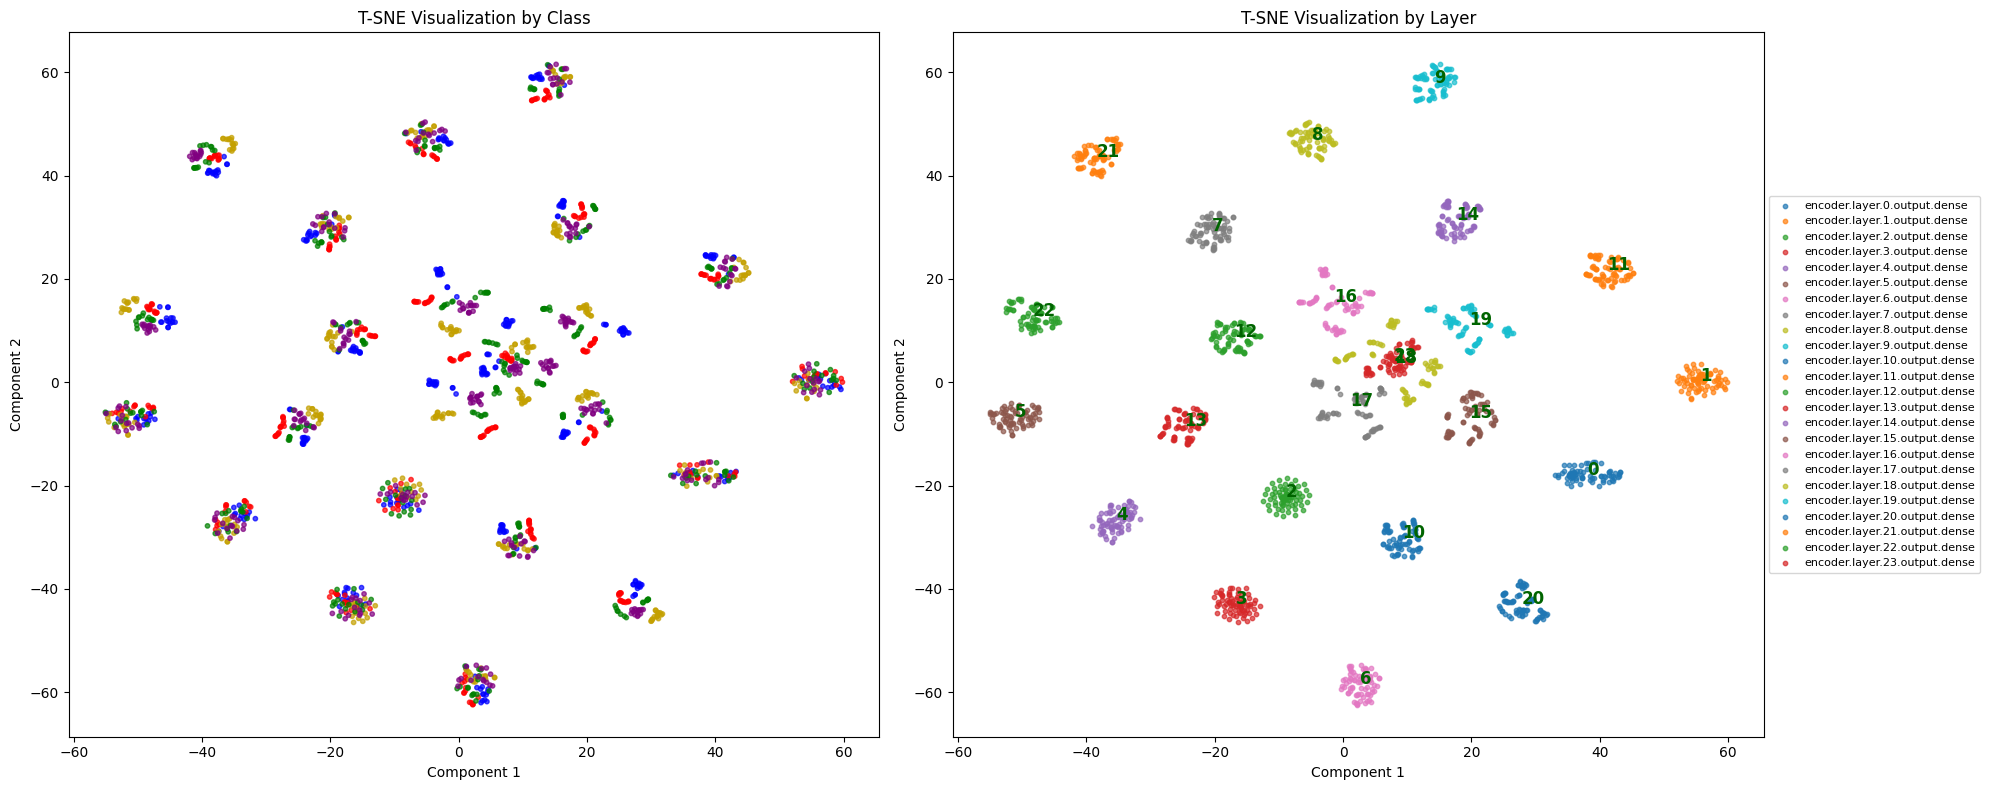

In [23]:

# Load the model and feature extractor
model_name = "microsoft/beit-large-patch16-512"
model = AutoModel.from_pretrained(model_name)

# Suppress uninitialized pooler weights warning
if hasattr(model, 'pooler'):
   model.pooler = None

feature_extractor = AutoImageProcessor.from_pretrained(model_name)

# Move the model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device).eval()

# Define the dataset
data_dir = "/content/sample_data/shapes"
transform = Compose([
    Resize((512, 512)),  # Resize to model's input size
    ToTensor(),  # Convert image to PyTorch tensor
])
dataset = ImageFolder(data_dir, transform=transform)

# Debug the transformation
def debug_transform(dataset, feature_extractor):
    for img, label in dataset:
        print(f"Original Image Shape: {img.size}")
        inputs = feature_extractor(images=[img.permute(1, 2, 0).numpy()], return_tensors="pt")["pixel_values"]
        print(f"Processed Image Shape: {inputs.shape}")
        break

debug_transform(dataset, feature_extractor)

# Define the layers to analyze
layers_to_analyze_vit = [
    "encoder.layer.0.output.dense",
    "encoder.layer.1.output.dense",
    "encoder.layer.2.output.dense",
    "encoder.layer.3.output.dense",
    "encoder.layer.4.output.dense",
    "encoder.layer.5.output.dense",
    "encoder.layer.6.output.dense",
    "encoder.layer.7.output.dense",
    "encoder.layer.8.output.dense",
    "encoder.layer.9.output.dense",
    "encoder.layer.10.output.dense",
    "encoder.layer.11.output.dense",
    "encoder.layer.12.output.dense",
    "encoder.layer.13.output.dense",
    "encoder.layer.14.output.dense",
    "encoder.layer.15.output.dense",
    "encoder.layer.16.output.dense",
    "encoder.layer.17.output.dense",
    "encoder.layer.18.output.dense",
    "encoder.layer.19.output.dense",
    "encoder.layer.20.output.dense",
    "encoder.layer.21.output.dense",
    "encoder.layer.22.output.dense",
    "encoder.layer.23.output.dense"
]

# Extract and visualize T-SNE maps for both classes and layers
extract_visualize_save_and_show_tsne(model, feature_extractor, dataset, layers_to_analyze_vit, num_classes=len(dataset.classes))


In [ ]:
from transformers import AutoModel

# Load your model
model_name = "microsoft/beit-large-patch16-512"
model = AutoModel.from_pretrained(model_name)

# Print all layer names
for name, module in model.named_modules():
    print(name)



embeddings
embeddings.patch_embeddings
embeddings.patch_embeddings.projection
embeddings.dropout
encoder
encoder.layer
encoder.layer.0
encoder.layer.0.attention
encoder.layer.0.attention.attention
encoder.layer.0.attention.attention.query
encoder.layer.0.attention.attention.key
encoder.layer.0.attention.attention.value
encoder.layer.0.attention.attention.dropout
encoder.layer.0.attention.attention.relative_position_bias
encoder.layer.0.attention.output
encoder.layer.0.attention.output.dense
encoder.layer.0.attention.output.dropout
encoder.layer.0.intermediate
encoder.layer.0.intermediate.dense
encoder.layer.0.intermediate.intermediate_act_fn
encoder.layer.0.output
encoder.layer.0.output.dense
encoder.layer.0.output.dropout
encoder.layer.0.layernorm_before
encoder.layer.0.drop_path
encoder.layer.0.layernorm_after
encoder.layer.1
encoder.layer.1.attention
encoder.layer.1.attention.attention
encoder.layer.1.attention.attention.query
encoder.layer.1.attention.attention.key
encoder.layer.1

In [ ]:
from transformers import AutoModel

# Load the pretrained DINOv2 model
model_name = "microsoft/beit-large-patch16-512"
model = AutoModel.from_pretrained(model_name)  # Load the model
model.eval()  # Set the model to evaluation mode

# Print the model structure to explore layer names
print(model)


config.json:   0%|          | 0.00/69.9k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

BeitModel(
  (embeddings): BeitEmbeddings(
    (patch_embeddings): BeitPatchEmbeddings(
      (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): BeitEncoder(
    (layer): ModuleList(
      (0): BeitLayer(
        (attention): BeitAttention(
          (attention): BeitSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=False)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (relative_position_bias): BeitRelativePositionBias()
          )
          (output): BeitSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): BeitIntermediate(
          (dense): Linear(in_features=1024, o

**Model3: timm/vit_large_patch16_224.augreg_in21k**

---



In [ ]:
!pip install timm

In [29]:
import timm

# Load the model
model_name = "vit_large_patch16_224.augreg_in21k"
model = timm.create_model(model_name, pretrained=True)

# Print all layer names
for name, module in model.named_modules():
    print(name)


model.safetensors:   0%|          | 0.00/1.30G [00:00<?, ?B/s]


patch_embed
patch_embed.proj
patch_embed.norm
pos_drop
patch_drop
norm_pre
blocks
blocks.0
blocks.0.norm1
blocks.0.attn
blocks.0.attn.qkv
blocks.0.attn.q_norm
blocks.0.attn.k_norm
blocks.0.attn.attn_drop
blocks.0.attn.proj
blocks.0.attn.proj_drop
blocks.0.ls1
blocks.0.drop_path1
blocks.0.norm2
blocks.0.mlp
blocks.0.mlp.fc1
blocks.0.mlp.act
blocks.0.mlp.drop1
blocks.0.mlp.norm
blocks.0.mlp.fc2
blocks.0.mlp.drop2
blocks.0.ls2
blocks.0.drop_path2
blocks.1
blocks.1.norm1
blocks.1.attn
blocks.1.attn.qkv
blocks.1.attn.q_norm
blocks.1.attn.k_norm
blocks.1.attn.attn_drop
blocks.1.attn.proj
blocks.1.attn.proj_drop
blocks.1.ls1
blocks.1.drop_path1
blocks.1.norm2
blocks.1.mlp
blocks.1.mlp.fc1
blocks.1.mlp.act
blocks.1.mlp.drop1
blocks.1.mlp.norm
blocks.1.mlp.fc2
blocks.1.mlp.drop2
blocks.1.ls2
blocks.1.drop_path2
blocks.2
blocks.2.norm1
blocks.2.attn
blocks.2.attn.qkv
blocks.2.attn.q_norm
blocks.2.attn.k_norm
blocks.2.attn.attn_drop
blocks.2.attn.proj
blocks.2.attn.proj_drop
blocks.2.ls1
blocks.

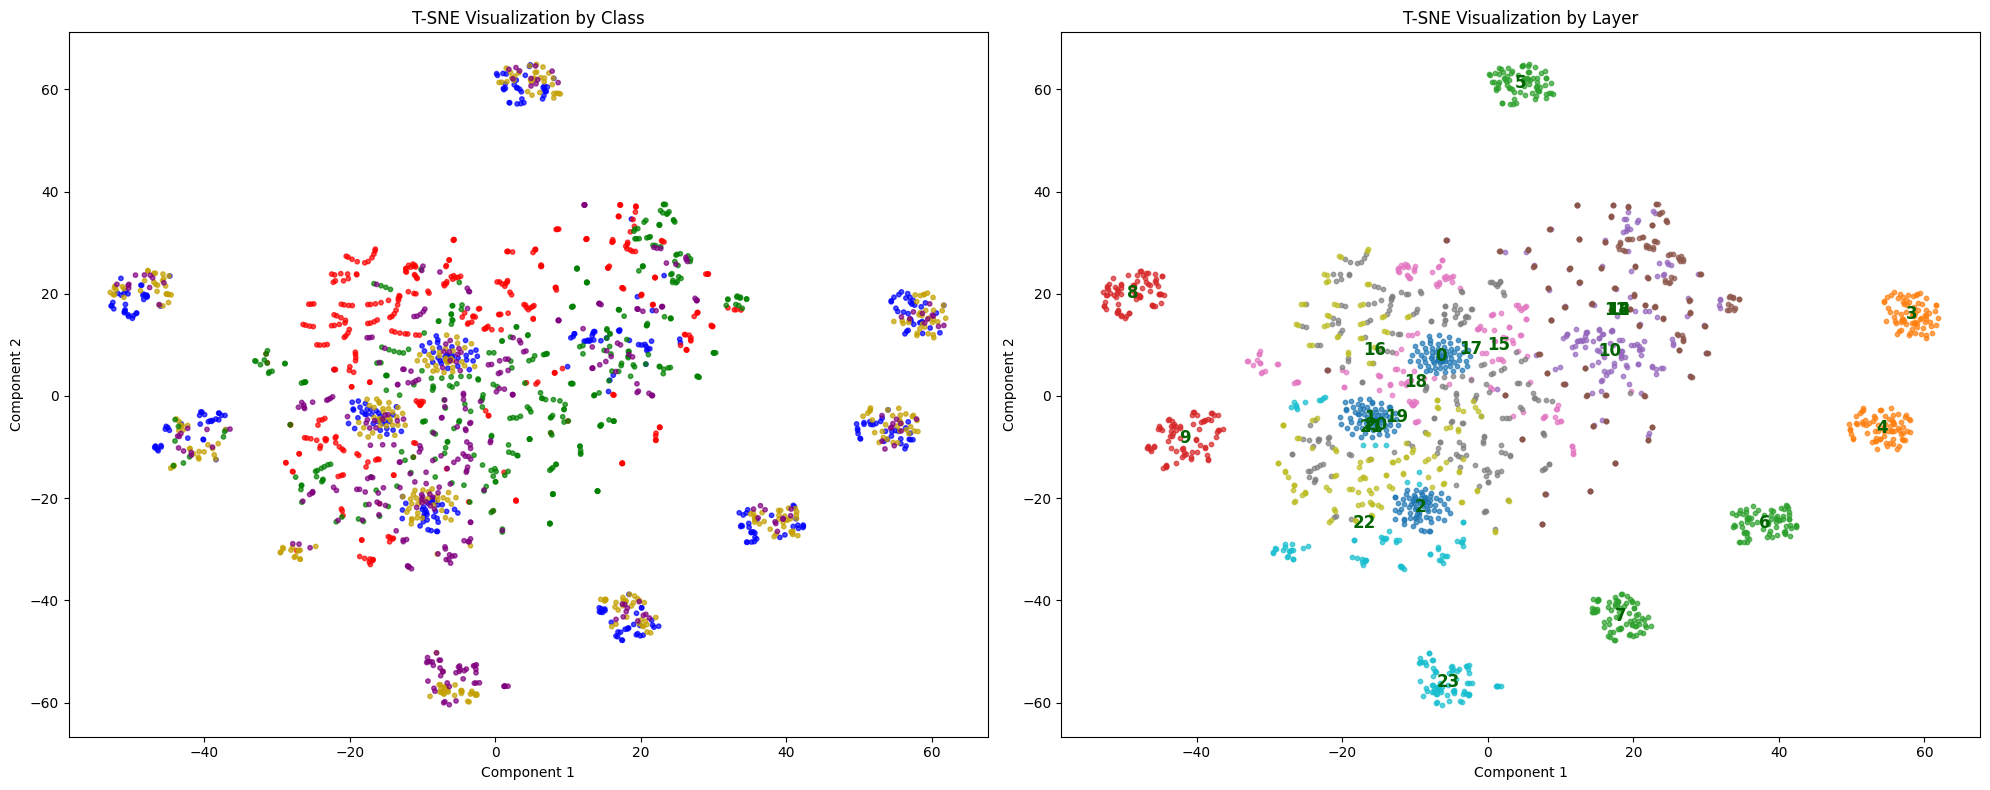

In [34]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Compose
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import timm

# Define the color palette for classes
class_colors = ['blue', 'red', '#C4A000', 'green', 'purple']  # Custom colors for 5 classes

# Function to extract and visualize combined latent representations
def extract_and_visualize_combined_latent_representations(model, images, layer_names, num_classes):
    all_activations = []  # Combined activations across layers
    all_labels = []  # Ground truth labels
    layer_labels = []  # To track the layer index of each activation

    # DataLoader for batch processing
    data_loader = DataLoader(images, batch_size=32, shuffle=False)

    # Forward hooks to capture activations from specific layers
    hooks = []

    def create_hook(layer_name, layer_idx):
        def hook_fn(module, input, output):
            if isinstance(output, tuple):
                output = output[0]  # Use the first element if it's a tuple
            flat_output = output.view(output.size(0), -1)  # Flatten spatial dimensions
            all_activations.append(flat_output.detach().cpu().numpy())  # Append activations
            layer_labels.extend([layer_idx] * flat_output.size(0))  # Track which layer the activations belong to
        return hook_fn

    # Attach hooks to the specified layers
    for idx, layer_name in enumerate(layer_names):
        layer = dict([*model.named_modules()])[layer_name]
        hooks.append(layer.register_forward_hook(create_hook(layer_name, idx)))

    # Process the data
    for batch_idx, (batch, target) in enumerate(data_loader):
        with torch.no_grad():
            inputs = batch.to("cuda" if torch.cuda.is_available() else "cpu")
            model(inputs)

            # Expand class labels for each layer
            repeated_labels = np.repeat(target.numpy(), len(layer_names))
            all_labels.extend(repeated_labels)

    # Remove hooks after processing
    for hook in hooks:
        hook.remove()

    # Concatenate activations and labels
    all_activations = np.concatenate(all_activations, axis=0)
    all_labels = np.array(all_labels)  # Convert list to NumPy array
    layer_labels = np.array(layer_labels)

    # Apply T-SNE to combined activations
    tsne = TSNE(n_components=2, perplexity=min(30, len(all_labels) - 1), random_state=0)
    reduced_activations = tsne.fit_transform(all_activations)

    # Create side-by-side plots for classes and layers
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Map class labels to colors
    colors_for_classes = [class_colors[label % len(class_colors)] for label in all_labels]

    # Plot T-SNE by classes
    axes[0].scatter(
        reduced_activations[:, 0],
        reduced_activations[:, 1],
        c=colors_for_classes,  # Use custom class colors
        alpha=0.7,
        s=10
    )
    axes[0].set_title('T-SNE Visualization by Class')
    axes[0].set_xlabel('Component 1')
    axes[0].set_ylabel('Component 2')

    # Plot T-SNE by layers
    unique_layers = np.unique(layer_labels)
    cmap = plt.get_cmap('tab10')
    colors_for_layers = [cmap(i / len(unique_layers)) for i in range(len(unique_layers))]

    for i, layer_idx in enumerate(unique_layers):
        layer_mask = layer_labels == layer_idx
        layer_points = reduced_activations[layer_mask]

        # Scatter points for each layer
        axes[1].scatter(
            layer_points[:, 0],
            layer_points[:, 1],
            c=[colors_for_layers[layer_idx]],
            alpha=0.7,
            s=10
        )

        # Annotate the plot with the layer number
        centroid_x, centroid_y = layer_points.mean(axis=0)
        axes[1].text(
            centroid_x,
            centroid_y,
            str(layer_idx),
            fontsize=12,
            color='darkgreen',
            fontweight='bold',
            ha='center',
            va='center'
        )

    axes[1].set_title('T-SNE Visualization by Layer')
    axes[1].set_xlabel('Component 1')
    axes[1].set_ylabel('Component 2')

    plt.tight_layout()
    plt.savefig("tsne_visualization.png", dpi=300)  # Save high-resolution plot
    plt.show()


# Load the timm model
model_name = "vit_large_patch16_224.augreg_in21k"
model = timm.create_model(model_name, pretrained=True)

# Move the model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device).eval()

# Define the dataset
data_dir = "/content/sample_data/shapes"  # Update with your dataset path
transform = Compose([
    Resize((224, 224)),  # Resize to match model input size
    ToTensor(),  # Convert image to PyTorch tensor
])
dataset = ImageFolder(data_dir, transform=transform)

# Define the layers to analyze
layers_to_analyze_vit = [
    "blocks.0.mlp.fc2",
    "blocks.1.mlp.fc2",
    "blocks.2.mlp.fc2",
    "blocks.3.mlp.fc2",
    "blocks.4.mlp.fc2",
    "blocks.5.mlp.fc2",
    "blocks.6.mlp.fc2",
    "blocks.7.mlp.fc2",
    "blocks.8.mlp.fc2",
    "blocks.9.mlp.fc2",
    "blocks.10.mlp.fc2",
    "blocks.11.mlp.fc2",
    "blocks.12.mlp.fc2",
    "blocks.13.mlp.fc2",
    "blocks.14.mlp.fc2",
    "blocks.15.mlp.fc2",
    "blocks.16.mlp.fc2",
    "blocks.17.mlp.fc2",
    "blocks.18.mlp.fc2",
    "blocks.19.mlp.fc2",
    "blocks.20.mlp.fc2",
    "blocks.21.mlp.fc2",
    "blocks.22.mlp.fc2",
    "blocks.23.mlp.fc2"
]

# Extract and visualize combined latent representations
extract_and_visualize_combined_latent_representations(
    model, dataset, layers_to_analyze_vit, num_classes=len(dataset.classes)
)


**Model4: google/vit-large-patch16-224**

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-large-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


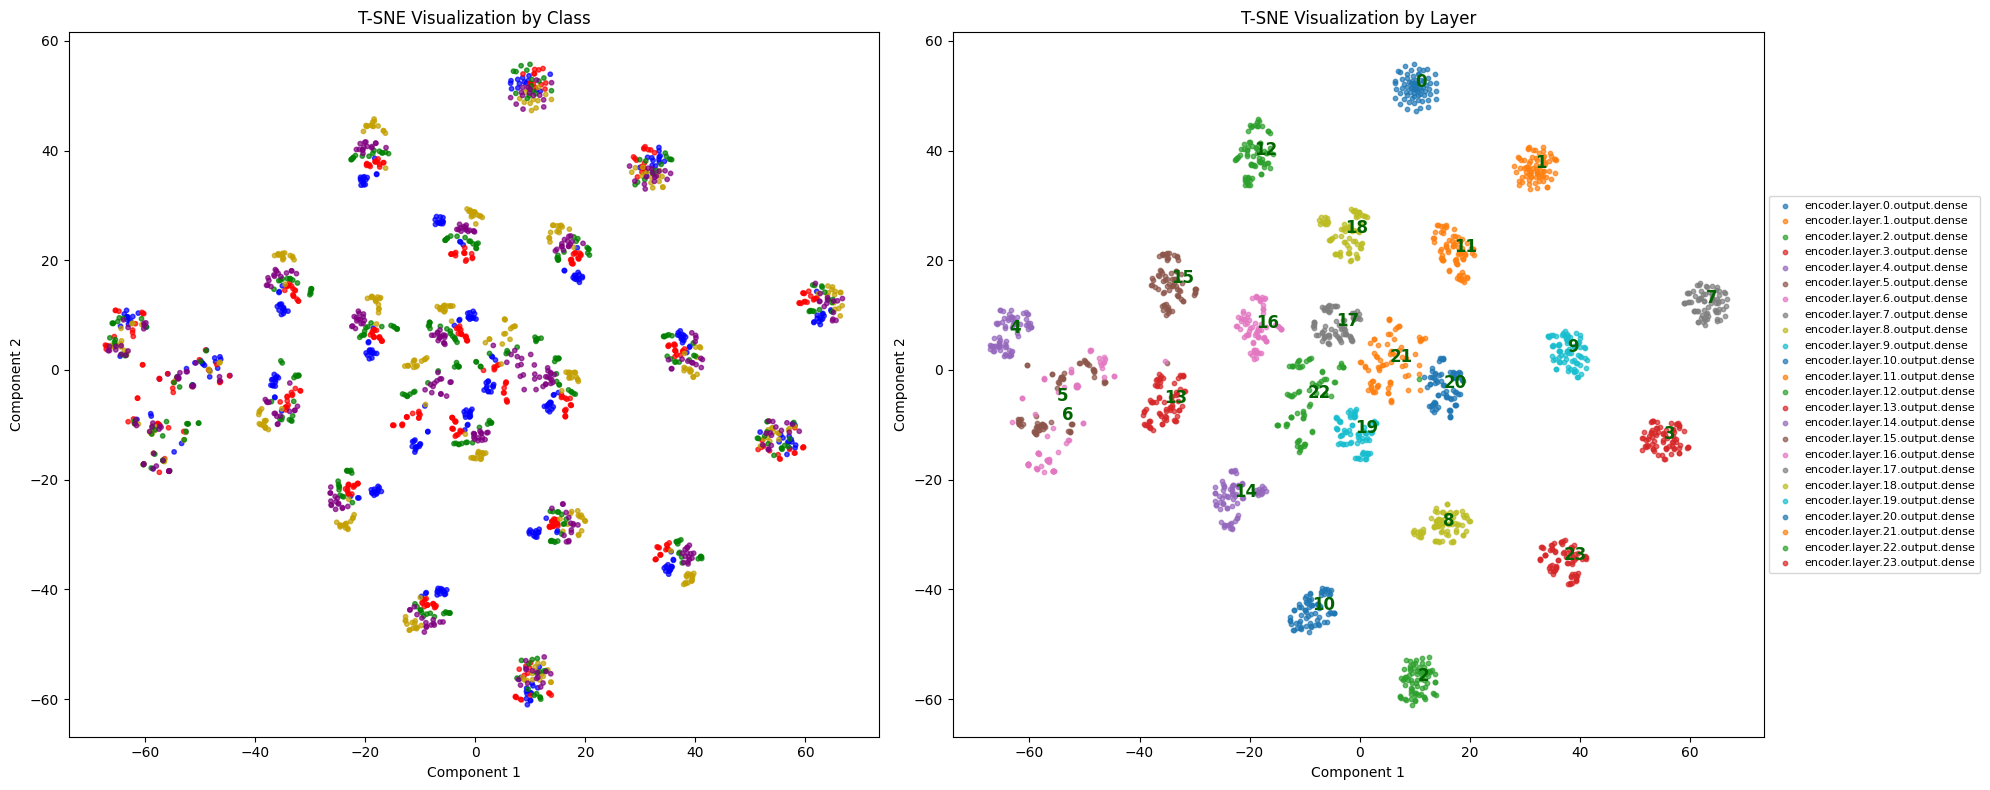

In [24]:

# Load the model and feature extractor
model_name = "google/vit-large-patch16-224"
model = AutoModel.from_pretrained(model_name)

# Suppress uninitialized pooler weights warning
if hasattr(model, 'pooler'):
    model.pooler = None

feature_extractor = AutoImageProcessor.from_pretrained(model_name)

# Move the model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device).eval()

# Define the dataset
data_dir = "/content/sample_data/shapes"
transform = Compose([
    Resize((224, 224)),  # Resize to model's input size
    ToTensor(),  # Convert image to PyTorch tensor
])
dataset = ImageFolder(data_dir, transform=transform)

# Define the layers to analyze
layers_to_analyze_vit = [
    "encoder.layer.0.output.dense",
    "encoder.layer.1.output.dense",
    "encoder.layer.2.output.dense",
    "encoder.layer.3.output.dense",
    "encoder.layer.4.output.dense",
    "encoder.layer.5.output.dense",
    "encoder.layer.6.output.dense",
    "encoder.layer.7.output.dense",
    "encoder.layer.8.output.dense",
    "encoder.layer.9.output.dense",
    "encoder.layer.10.output.dense",
    "encoder.layer.11.output.dense",
    "encoder.layer.12.output.dense",
    "encoder.layer.13.output.dense",
    "encoder.layer.14.output.dense",
    "encoder.layer.15.output.dense",
    "encoder.layer.16.output.dense",
    "encoder.layer.17.output.dense",
    "encoder.layer.18.output.dense",
    "encoder.layer.19.output.dense",
    "encoder.layer.20.output.dense",
    "encoder.layer.21.output.dense",
    "encoder.layer.22.output.dense",
    "encoder.layer.23.output.dense"
]

# Extract and visualize T-SNE maps for both classes and layers
extract_visualize_save_and_show_tsne(model, feature_extractor, dataset, layers_to_analyze_vit, num_classes=len(dataset.classes))

In [ ]:
from transformers import AutoModel

# Load your model
model_name = "google/vit-large-patch16-224"
model = AutoModel.from_pretrained(model_name)
print (model)
# Print all layer names
for name, module in model.named_modules():
    print(name)


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-large-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-23): 24 x ViTLayer(
        (attention): ViTSdpaAttention(
          (attention): ViTSdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=1024, out_features=4096, bias=True)
          (intermediate_act_fn

**Model5: facebook/vit-mae-large**

config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.32G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/217 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


Original Image Shape: torch.Size([3, 224, 224])
Processed Image Shape: torch.Size([1, 3, 224, 224])


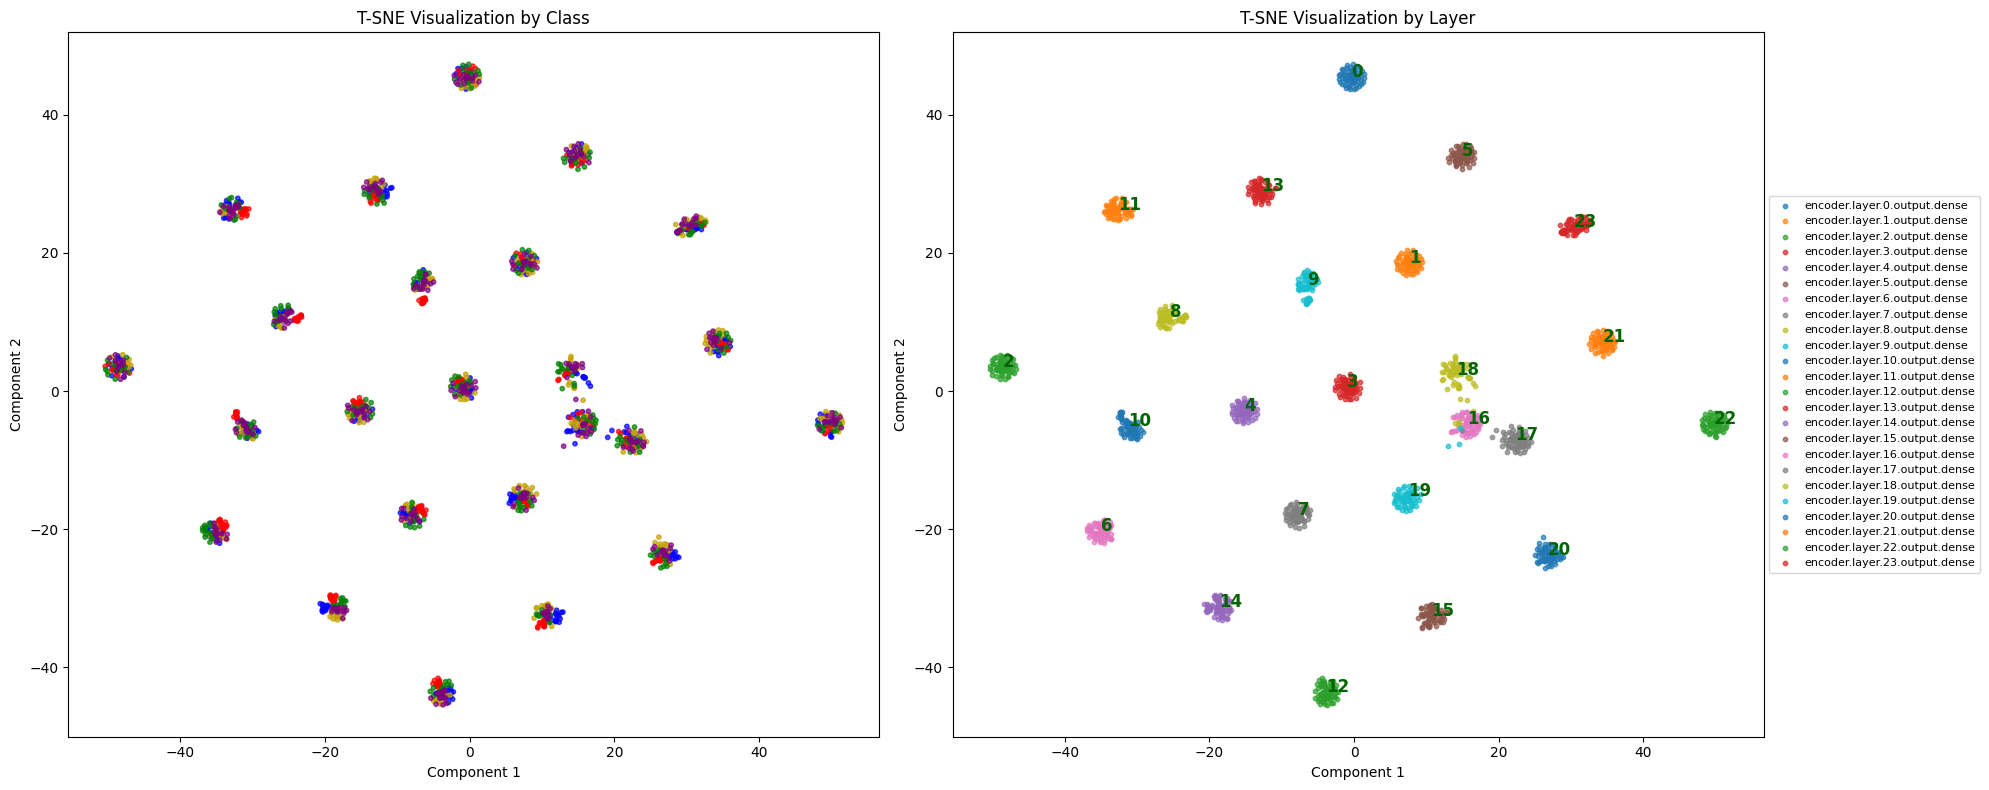

In [25]:
from transformers import AutoModel, AutoImageProcessor
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Compose

# Load the model and feature extractor
model_name = "facebook/vit-mae-large"
model = AutoModel.from_pretrained(model_name)

# Suppress uninitialized pooler weights warning
if hasattr(model, 'pooler'):
    model.pooler = None

feature_extractor = AutoImageProcessor.from_pretrained(model_name)

# Move the model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device).eval()

# Define the dataset
data_dir = "/content/sample_data/shapes"
transform = Compose([
    Resize((224, 224)),  # Resize to model's input size
    ToTensor(),  # Convert image to PyTorch tensor
])
dataset = ImageFolder(data_dir, transform=transform)

# Debug the transformation
def debug_transform(dataset, feature_extractor):
    for img, label in dataset:
        print(f"Original Image Shape: {img.size()}")
        inputs = feature_extractor(images=[img.permute(1, 2, 0).numpy()], return_tensors="pt")["pixel_values"]
        print(f"Processed Image Shape: {inputs.shape}")
        break

debug_transform(dataset, feature_extractor)

# Define the layers to analyze
layers_to_analyze_vit = [
    "encoder.layer.0.output.dense",
    "encoder.layer.1.output.dense",
    "encoder.layer.2.output.dense",
    "encoder.layer.3.output.dense",
    "encoder.layer.4.output.dense",
    "encoder.layer.5.output.dense",
    "encoder.layer.6.output.dense",
    "encoder.layer.7.output.dense",
    "encoder.layer.8.output.dense",
    "encoder.layer.9.output.dense",
    "encoder.layer.10.output.dense",
    "encoder.layer.11.output.dense",
    "encoder.layer.12.output.dense",
    "encoder.layer.13.output.dense",
    "encoder.layer.14.output.dense",
    "encoder.layer.15.output.dense",
    "encoder.layer.16.output.dense",
    "encoder.layer.17.output.dense",
    "encoder.layer.18.output.dense",
    "encoder.layer.19.output.dense",
    "encoder.layer.20.output.dense",
    "encoder.layer.21.output.dense",
    "encoder.layer.22.output.dense",
    "encoder.layer.23.output.dense"
]

# Extract and visualize T-SNE maps for both classes and layers
extract_visualize_save_and_show_tsne(model, feature_extractor, dataset, layers_to_analyze_vit, num_classes=len(dataset.classes))


In [ ]:
from transformers import AutoModel

# Load your model
model_name = "facebook/vit-mae-large"
model = AutoModel.from_pretrained(model_name)
print (model)
# Print all layer names
for name, module in model.named_modules():
    print(name)


config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.32G [00:00<?, ?B/s]

ViTMAEModel(
  (embeddings): ViTMAEEmbeddings(
    (patch_embeddings): ViTMAEPatchEmbeddings(
      (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
  )
  (encoder): ViTMAEEncoder(
    (layer): ModuleList(
      (0-23): 24 x ViTMAELayer(
        (attention): ViTMAESdpaAttention(
          (attention): ViTMAESdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTMAESelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTMAEIntermediate(
          (dense): Linear(in_features=1024, out_features=4096, bias=True)
          (intermediate_act_fn): GELUActivation(

Streaming output truncated to the last 5000 lines.
  [ 0.05980617 -0.07148951  0.1697299  ... -0.13658051 -0.08850396
    0.03331058]
  [ 0.07797034 -0.07213569  0.16647996 ... -0.15230617 -0.08494797
    0.02447608]]

 [[ 0.0119616   0.02052191  0.18419282 ... -0.13530289 -0.07585643
    0.05239528]
  [ 0.0726371  -0.03706794  0.17563656 ... -0.1589962  -0.08881659
    0.04670487]
  [ 0.0779435  -0.0477896   0.1829512  ... -0.14859433 -0.07879369
    0.04018063]
  ...
  [ 0.0430542  -0.06373005  0.17044483 ... -0.13993883 -0.1035204
    0.02439494]
  [ 0.06345834 -0.07229233  0.16660073 ... -0.13776658 -0.08834045
    0.02911957]
  [ 0.08258554 -0.07309989  0.16339236 ... -0.15419754 -0.08529717
    0.01994671]]]
Layer: encoder.layer.3.mlp.fc2, Activation Shape: (75, 257, 1024)
Class Distributions (raw): [[[ 0.13758256  0.03667124  0.09355123 ...  0.0119413   0.14505672
    0.06346854]
  [ 0.23657665 -0.03569389  0.06204905 ...  0.12996896  0.1617221
   -0.17238382]
  [ 0.21304855 -0.

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-large-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Layer: encoder.layer.0.output.dense, Collected Output Shape: torch.Size([32, 197, 1024])
Layer: encoder.layer.1.output.dense, Collected Output Shape: torch.Size([32, 197, 1024])
Layer: encoder.layer.2.output.dense, Collected Output Shape: torch.Size([32, 197, 1024])
Layer: encoder.layer.3.output.dense, Collected Output Shape: torch.Size([32, 197, 1024])
Layer: encoder.layer.4.output.dense, Collected Output Shape: torch.Size([32, 197, 1024])
Layer: encoder.layer.5.output.dense, Collected Output Shape: torch.Size([32, 197, 1024])
Layer: encoder.layer.6.output.dense, Collected Output Shape: torch.Size([32, 197, 1024])
Layer: encoder.layer.7.output.dense, Collected Output Shape: torch.Size([32, 197, 1024])
Layer: encoder.layer.8.output.dense, Collected Output Shape: torch.Size([32, 197, 1024])
Layer: encoder.layer.9.output.dense, Collected Output Shape: torch.Size([32, 197, 1024])
Layer: encoder.layer.10.output.dense, Collected Output Shape: torch.Size([32, 197, 1024])
Layer: encoder.layer

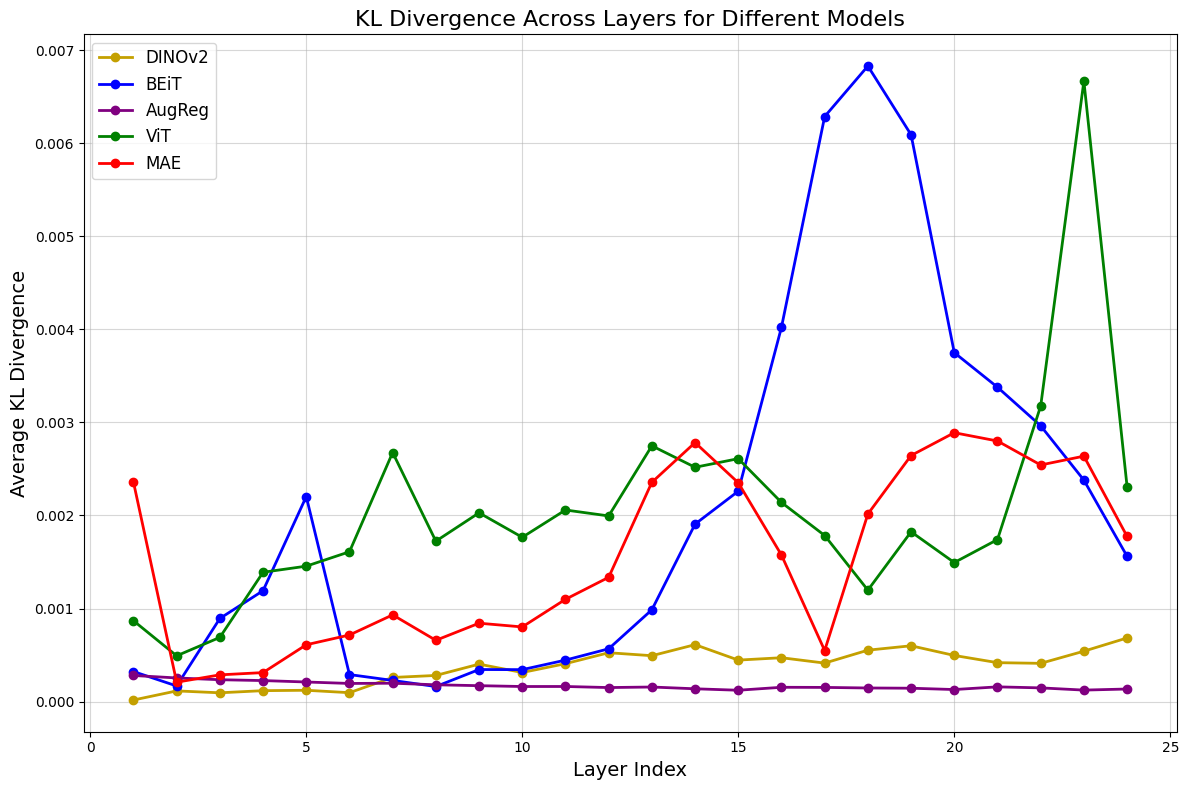

In [57]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor
from scipy.stats import entropy
from scipy.special import softmax
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoImageProcessor
import timm

# Dataset setup
data_dir = "/content/sample_data/shapes"  # Update with your dataset path
transform = Compose([
    Resize((224, 224)),  # Resize for compatibility
    ToTensor(),  # Convert to PyTorch tensor
])
dataset = ImageFolder(data_dir, transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Function to attach hooks and collect activations
def collect_activations(model, layer_names, data_loader, device):
    activations = {layer: [] for layer in layer_names}
    hooks = []

    def create_hook(layer_name):
        def hook_fn(module, input, output):
            if isinstance(output, tuple):  # Handle tuple outputs
                output = output[0]
            print(f"Layer: {layer_name}, Collected Output Shape: {output.shape}")
            activations[layer_name].append(output.detach().cpu().numpy())
        return hook_fn

    # Attach hooks
    for layer_name in layer_names:
        if layer_name not in dict(model.named_modules()):
            print(f"Warning: Layer {layer_name} not found in model. Skipping...")
            continue
        layer = dict(model.named_modules())[layer_name]
        hooks.append(layer.register_forward_hook(create_hook(layer_name)))

    # Pass data through the model
    for batch, _ in data_loader:
        batch = batch.to(device)
        with torch.no_grad():
            model(batch)

    # Remove hooks
    for hook in hooks:
        hook.remove()

    # Ensure consistent shapes for activations
    for layer_name in layer_names:
        if activations[layer_name]:
            try:
                activations[layer_name] = np.concatenate(activations[layer_name], axis=0)
            except ValueError:
                print(f"Error concatenating activations for layer {layer_name}.")
                print(f"Shapes: {[a.shape for a in activations[layer_name]]}")
                activations[layer_name] = None
        else:
            print(f"Warning: No activations collected for layer {layer_name}.")
            activations[layer_name] = None
    return activations

# Function to calculate KL divergence
def calculate_kl_divergence(activations, labels, num_classes, epsilon=1e-8):
    kl_divergence = []
    for layer_name, layer_activations in activations.items():
        if layer_activations is None:
            kl_divergence.append(0)
            continue

        print(f"Layer: {layer_name}, Activation Shape: {layer_activations.shape}")

        # Group activations by class
        class_distributions = []
        for c in range(num_classes):
            class_activations = layer_activations[labels == c]
            if len(class_activations) > 0:
                mean_activation = class_activations.mean(axis=0)
                class_distributions.append(mean_activation)

        if len(class_distributions) < 2:
            kl_divergence.append(0)
            continue

        # Stack class distributions
        class_distributions = np.stack(class_distributions, axis=0)
        print(f"Class Distributions (raw): {class_distributions}")

        # Apply stable softmax for normalization
        class_distributions = np.clip(np.array(class_distributions), epsilon, 1 - epsilon)
        class_distributions = softmax(class_distributions, axis=1)

        # Calculate pairwise KL divergence
        kl = []
        for i in range(len(class_distributions)):
            for j in range(len(class_distributions)):
                if i != j:
                    kl.append(entropy(class_distributions[i], class_distributions[j]))
        kl_divergence.append(np.mean(kl))  # Average KL divergence for this layer
    return kl_divergence

# Models and their layers to analyze
models_info = {
    "facebook/dinov2-large": {
        "model_fn": AutoModel.from_pretrained,
        "layer_names": [
            f"encoder.layer.{i}.mlp.fc2" for i in range(24)
        ]
    },
    "microsoft/beit-large-patch16-512": {
        "model_fn": AutoModel.from_pretrained,
        "layer_names": [
            f"encoder.layer.{i}.output.dense" for i in range(24)
        ]
    },
    "vit_large_patch16_224.augreg_in21k": {
        "model_fn": timm.create_model,
        "layer_names": [
            f"blocks.{i}.mlp.fc2" for i in range(24)
        ]
    },
    "google/vit-large-patch16-224": {
        "model_fn": AutoModel.from_pretrained,
        "layer_names": [
            f"encoder.layer.{i}.output.dense" for i in range(24)
        ]
    },
    "facebook/vit-mae-large": {
        "model_fn": AutoModel.from_pretrained,
        "layer_names": [
            f"encoder.layer.{i}.output.dense" for i in range(24)
        ]
    },
}

# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"

# Collect KL divergence for each model
kl_divergence_results = {}

for model_name, info in models_info.items():
    print(f"Processing model: {model_name}")
    # Load the model
    if "timm" in model_name:
        model = info["model_fn"](model_name, pretrained=True)
    else:
        model = info["model_fn"](model_name)

    model.to(device).eval()

    # Collect activations
    activations = collect_activations(model, info["layer_names"], data_loader, device)

    # Debug: Check activations
    print(f"Collected activations for {model_name}: {list(activations.keys())}")

    # Assign dataset labels
    labels = np.array([sample[1] for sample in dataset.samples])

    # Calculate KL divergence
    kl_divergence = calculate_kl_divergence(activations, labels, num_classes=len(dataset.classes))
    kl_divergence_results[model_name] = kl_divergence
    print(f"KL Divergence for {model_name}: {kl_divergence}")

# Define colors and labels for each model
plot_styles = {
    "facebook/dinov2-large": {"color": "#C4A000", "label": "DINOv2"},
    "microsoft/beit-large-patch16-512": {"color": "blue", "label": "BEiT"},
    "vit_large_patch16_224.augreg_in21k": {"color": "purple", "label": "AugReg"},
    "google/vit-large-patch16-224": {"color": "green", "label": "ViT"},
    "facebook/vit-mae-large": {"color": "red", "label": "MAE"},
}

# Plot KL divergence across layers for all models
plt.figure(figsize=(12, 8))
for model_name, kl_divergence in kl_divergence_results.items():
    style = plot_styles.get(model_name, {})
    plt.plot(
        range(1, 25),
        kl_divergence,
        label=style.get("label", model_name),
        color=style.get("color", "black"),
        marker='o',
        linewidth=2,
    )

plt.xlabel("Layer Index", fontsize=14)
plt.ylabel("Average KL Divergence", fontsize=14)
plt.title("KL Divergence Across Layers for Different Models", fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()
